In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

from src.component import ComponentCreator
from src.network import Node,Edge,Network
from src.splitter import Splitter
from src.model import Model
from src.util import Util

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.ensemble import GradientBoostingClassifier

# Initiate MongoDB Collection

In [2]:
client = MongoClient()
papers = client.capstone.papers

# Create Randomly Generated Components

In [3]:
comp_creator = ComponentCreator(collection=papers)
E,X = comp_creator.random_construct(10000)

# Split Sample Records and Train Recommender Model

In [9]:
X0,Xt,y0,yt,E0,Et = Splitter.split(X, 10.0, random_state=5476)

In [10]:
recommender = Model(
    GradientBoostingClassifier(n_estimators=5000, subsample=0.9, max_features='sqrt', max_depth=2), 
    ['topics','title','abstract','year','n_authors']
)

In [11]:
recommender.fit(X0)

# Update Network to Include All Records
    Because the model keeps its own record of nodes that can be recommended,
    it must be updated to account for missing records in the test set. In a
    real-world case, this is not an issue as inputs will not be added to the
    network or compared against real edges.

In [12]:
recommender._update_network(X0)
recommender._update_network(Xt)

# Plot ROC Curves
    The model is predispositioned to favor metrics like AUC 
    when the test set is comparing true edges to random pairs.
    This is because the similarity of any two random nodes is 
    likely to be substantially smaller than a real edge.
    Changing the method the nodes are collected via the
    ComponentCreator class adjusts AUC within a range of
    around 0.70-0.97. The 'random_construct' method was chosen
    here in order to improve the variety of recommendations.

In [13]:
pred_0 = recommender.predict_proba(E0)[:, 1]
pred_t = recommender.predict_proba(Et)[:, 1]

Train AUC: 0.9364413254629876
Test AUC: 0.9031000902516629


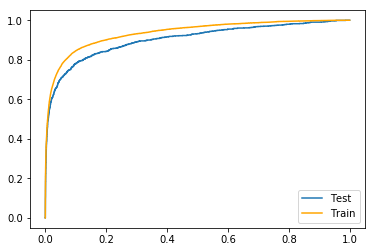

In [14]:
print('Train AUC:', roc_auc_score(y_true=y0.astype(int), 
                              y_score=pred_0))
print('Test AUC:', roc_auc_score(y_true=yt.astype(int), 
                             y_score=pred_t))

fig, ax = plt.subplots()
tpr, fpr, thr = roc_curve(y_true=yt.astype(int), 
                          y_score=pred_t)
ax.plot(tpr, fpr, label='Test')
tpr, fpr, thr = roc_curve(y_true=y0.astype(int), 
                          y_score=pred_0)
ax.plot(tpr, fpr, color='orange', label='Train')
ax.legend()